<a href="https://colab.research.google.com/github/leeraaz/SkinDiseaseDiagnosisNepal/blob/main/src/colab/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 745.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 34.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow


In [2]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

In [3]:
# TPU Initialization
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default for CPU and GPU
    print("Running on", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

Running on TPU: 


In [4]:
def create_generators(train_dir, test_dir, image_size=(299, 299), batch_size=32):
    """Creates train and validation generators using ImageDataGenerator."""
    # Augment training data and rescale
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode="nearest"
    )

    # Only rescale validation data
    validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Create training generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Create validation generator
    validation_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator


In [5]:
def build_inceptionv3_model(num_classes):
    """
    Builds an InceptionV3 model with top layers for classification.
    The base is frozen to preserve pre-trained weights.
    """
    inception_base = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )
    # Freeze the base model
    inception_base.trainable = False

    # Build top layers
    input_tensor = Input(shape=(299, 299, 3))
    x = inception_base(input_tensor, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [6]:
def train_model(train_generator, validation_generator, strategy, initial_lr=1e-3, epochs=20):
    """Trains the model under a given strategy with specified hyperparameters."""
    # Compute number of classes
    num_classes = train_generator.num_classes

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = dict(enumerate(class_weights))

    # Build and compile model inside strategy scope
    with strategy.scope():
        model = build_inceptionv3_model(num_classes)
        model.compile(
            optimizer=Adam(learning_rate=initial_lr),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'AUC']
        )

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


In [7]:
# Adjust these paths if you're using a different directory structure
train_dir = '/content/drive/MyDrive/SkinDataset/data5/train'
test_dir = '/content/drive/MyDrive/SkinDataset/data5/test'

# Parameters
batch_size = 32
image_size = (299, 299)  # Best size for InceptionV3
epochs = 20
initial_lr = 1e-3

# Create the data generators
train_generator, validation_generator = create_generators(
    train_dir=train_dir,
    test_dir=test_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Train the model
model, history = train_model(
    train_generator=train_generator,
    validation_generator=validation_generator,
    strategy=strategy,
    initial_lr=initial_lr,
    epochs=epochs
)


Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
188/188 [==============================] - 1698s 9s/step - loss: 1.0440 - accuracy: 0.6109 - auc: 0.8487 - val_loss: 0.7833 - val_accuracy: 0.6988 - val_auc: 0.9078 - lr: 0.0010
Epoch 2/20
188/188 [==============================] - 141s 748ms/step - loss: 0.8013 - accuracy: 0.6708 - auc: 0.8928 - val_loss: 0.6937 - val_accuracy: 0.7139 - val_auc: 0.9200 - lr: 0.0010
Epoch 3/20
188/188 [==============================] - 141s 748ms/step - loss: 0.7345 - accuracy: 0.6938 - auc: 0.9078 - val_loss: 0.6639 - val_accuracy: 0.7337 - val_auc: 0.9249 - lr: 0.0010
Epoch 4/20
188/188 [==============================] - 142s 756ms/step - loss: 0.7176 - accuracy: 0.7001 - auc: 0.9123 - val_loss: 0.6489 - val_accuracy: 0.7465 - val_auc: 0.9282 - lr: 0.0010
Epoch 5/20
188/188 [==============================] - 141s 749ms/step - loss: 0.6988 - ac

In [8]:
# Evaluate model performance
val_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=val_steps, verbose=1)
y_true = validation_generator.classes[:val_steps * validation_generator.batch_size]

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes,
      target_names=validation_generator.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


80/80 [==============================] - 55s 321ms/step
Classification Report:
              precision    recall  f1-score   support

        Acne       0.26      0.29      0.28       626
      Eczema       0.27      0.30      0.28       650
   Infection       0.28      0.25      0.26       650
   Malignant       0.26      0.24      0.25       634

    accuracy                           0.27      2560
   macro avg       0.27      0.27      0.27      2560
weighted avg       0.27      0.27      0.27      2560

Confusion Matrix:
[[180 171 140 135]
 [173 195 136 146]
 [164 184 161 141]
 [163 172 147 152]]


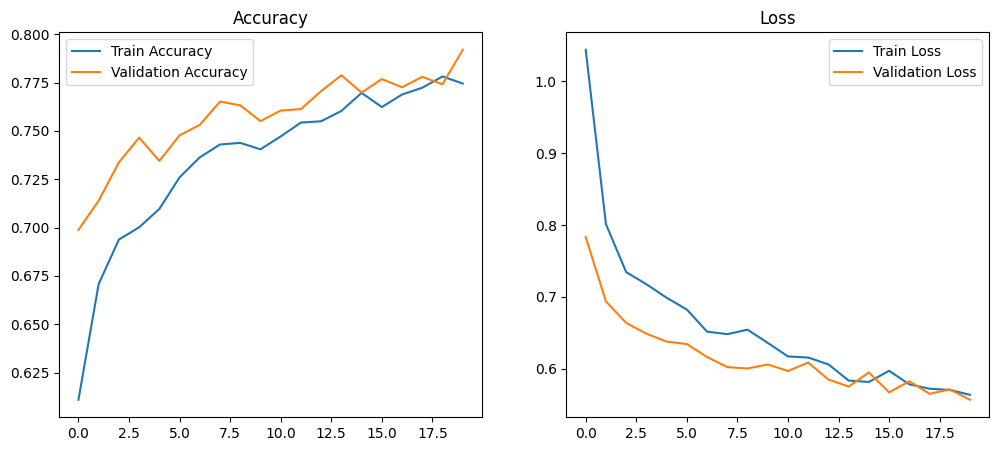

In [9]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [10]:
# Save Model
model.save("/content/drive/MyDrive/SkinDataset/hybrid_model_inceptionv3_tpu.keras")